### Installing necessary packages

In [51]:
!pip install wordcloud
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install nltk

### Importing required libraries

In [53]:
import pandas as pd
import numpy as np

import nltk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading the data

In [74]:
df = pd.read_csv("US_airline_tweets.csv")
df2 = df.copy() #for hashtags
df.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


## Data Cleaning
The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’.
Therefore, we need to “clean” the data.
- All html tags and attributes (i.e., /<[^>]+>/) are removed.
- Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
- All URLs are removed.
- All characters in the text are in lowercase.
- All stop words are removed.

In [75]:
# remove html tags with HTMLParser
## reference: https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python
from html.parser import HTMLParser
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [76]:
## Decode HTML Enteties
## reference: https://stackoverflow.com/questions/2087370/decode-html-entities-in-python-string
import html
def decode_html(string):
    clean_string = html.unescape(string)
    return clean_string

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus.
Using a generic list of stopwords can have a negative impact on sentiment analysis performance. As Neeraj Redrouthu stated in his comment, removing some common stopwords like "don't", "not", "couldn't" etc. can change sentiment of a sentence.

reference: http://oro.open.ac.uk/40666/

In [77]:
# making all charactors lowercase
df['text'] = df['text'].apply(lambda _: _.lower())

df['airlines']=''

# Assign each airline name in airline column based on the tweets
df['airlines'][df['text'].str.contains('virginamerica | virgin')] = 'Virgin America'
df['airlines'][df['text'].str.contains('united | unitedairlines | unitedairline')] = 'United'
df['airlines'][df['text'].str.contains('jetblue')] = 'Jet Blue'
df['airlines'][df['text'].str.contains('southwestair | soutwest')] = 'Soutwest'
df['airlines'][df['text'].str.contains('americanair | americanairline | americanairlines')] = 'American'
df['airlines'][df['text'].str.contains('usairways | usairway')] = 'US Airways'

#remove airline names
to_remove_list = ['virginamerica', 'vrigin', 'united', 'unitedair', 'jetblue', 'soutwest', 
                  'southwestair','american','americanair', 'americanairline', 'usair', 'usairways' ]
df['text'] = df['text'].str.replace('[^A-Za-z\s]+', '') # remove all special charactors
df['text'] = [' '.join([_ for _ in text.split() if _ not in to_remove_list]) for text in df['text']]


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is tryi

In [78]:
# using apply method to apply functions on pandas dataframe
# removing HTML charactors and attributes from the text column
# remove all the words having length 2 or less

df['text'] = df['text'].apply(decode_html).apply(strip_tags).apply(remove_stopwords).apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# removing urls using regex
# remove urls starting with "http" and "www"
df['text'] = df['text'].replace(r'http\S+', '', regex= True).replace(r'www\S+', '', regex= True)

# making all charactors lowercase
df['text'] = df['text'].apply(lambda _: _.lower())

In [79]:
# This function removes stop words from the tweets
# the input is the text and the result is clean_words

def remove_stopwords(input_text):
    stopwords_list = ['a', 'and', 'the', 'i', 'he', 'she', 'it', 'they', 
                      'them', 'has', 'have', 'had', 'etc', 'etc.', 'want', 
                      'say', 'said', 'one', 'info', 'guy']
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1] 
    return " ".join(clean_words)

In [80]:
to_remove_list = ['@VirginAmerica', '@united']
df['text'] = [' '.join([_ for _ in text.split() if _ not in to_remove_list]) for text in df['text']]

In [81]:
df.head()

,id,sentiment,negative_reason,user,retweet_count,text,airlines
0,5.703010e+17,positive,NaN,jnardino,0,plus youve added commercials experience tacky,Virgin America
1,5.703010e+17,negative,Bad Flight,jnardino,0,its really aggressive blast obnoxious entertai...,Virgin America
2,5.703010e+17,negative,Can't Tell,jnardino,0,its really big bad thing about,Virgin America
3,5.703010e+17,negative,Can't Tell,jnardino,0,seriously would pay flight for seats that didn...,Virgin America
4,5.703010e+17,positive,NaN,cjmcginnis,0,yes nearly every time fly this ear worm wont away,Virgin America


## Data Visualization

### Finding Hashtags in tweets

In [82]:
# function to collect hashtags
import re
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [83]:
# extracting hashtags from positive tweets where we define
# value of 1 for positive tweet and 0 for negative tweet
PH=[]

df['text'][df['sentiment'] == 'positive']

#HT_positive = hashtag_extract(df['text'][df['sentiment'] == 'positive'])

# extracting hashtags for negative tweet
HT_negative = hashtag_extract(df2['text'][df2['sentiment'] == 'negative'])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

[Text(0, 0.5, 'Count')]

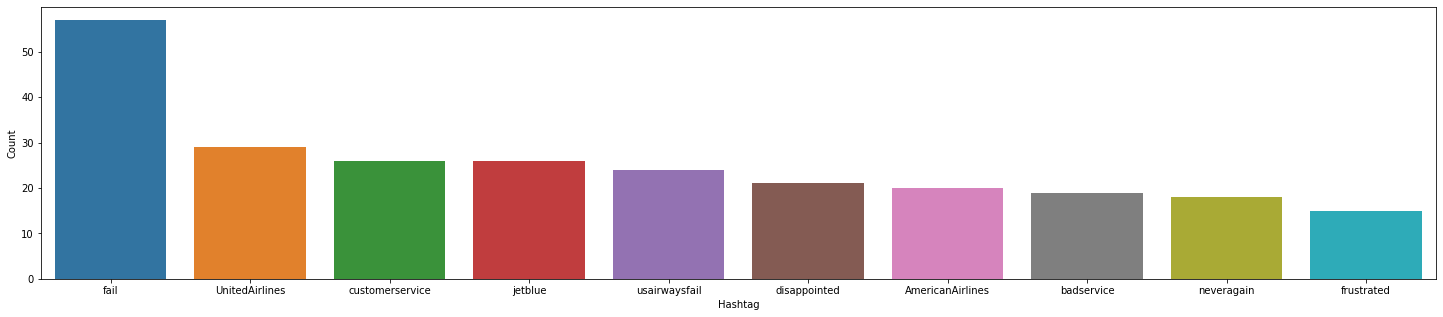

In [84]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(25,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')

In [85]:
# reference: https://stackoverflow.com/questions/45874879/extract-hashtags-from-columns-of-a-pandas-dataframe
#hashtags = df['text'].str.findall(r'#.*?(?=\s|$)')
#print(hashtags)

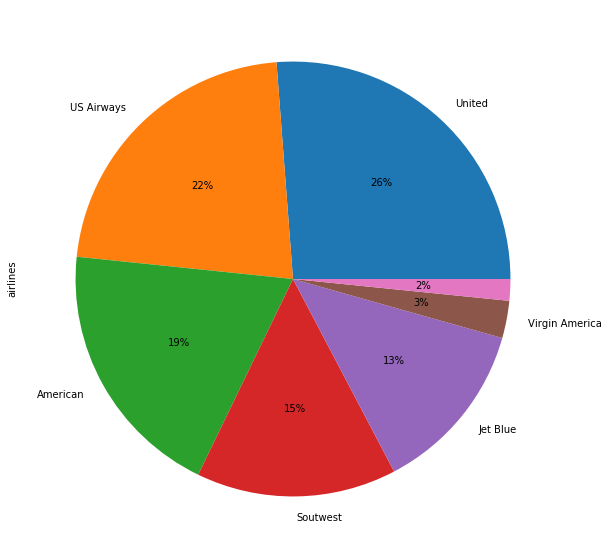

In [86]:
# looking at the tweets distributions between airlines
plt.figure(figsize=(15,10))
df['airlines'].value_counts().plot(kind='pie', autopct='%1.0f%%') 

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


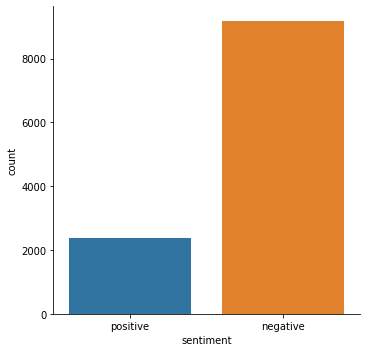

In [87]:
# exploring number of positive and negative tweets
sns.factorplot(x="sentiment", data=df, kind="count")

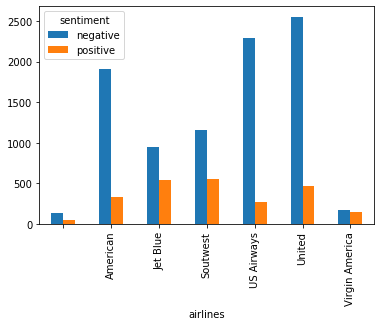

In [88]:
airline_sentiment = df.groupby(['airlines', 'sentiment']).sentiment.count().unstack()  
airline_sentiment.plot(kind='bar') 

### Exploring the Wordcloud

(-0.5, 799.5, 499.5, -0.5)

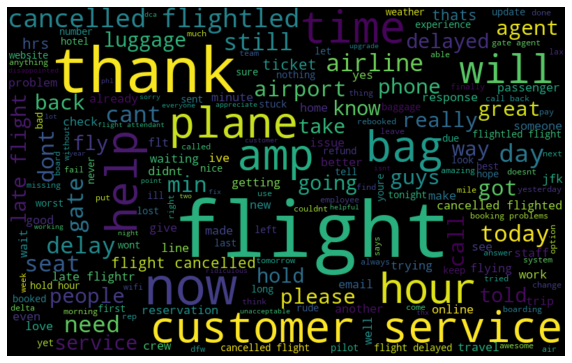

In [89]:
all_words = ' '.join([text for text in df['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

## Logistic Regression

In [90]:
features = df.iloc[:, 5].values  
labels = df.iloc[:, 1].values

In [95]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=2500, min_df=7, max_df=0.8)  
features = vectorizer.fit_transform(features).toarray()  

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)  

In [99]:
#prepare the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [100]:
lreg = LogisticRegression()
lreg.fit(X_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
y_pred = lreg.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))

0.86283249908428
